# 🧠 Conversational Transformer: Sıfırdan LLM Eğitimi

Bu not defteri, modern Büyük Dil Modellerinin (LLM) temelini oluşturan **Transformer** mimarisini, PyTorch kullanarak sıfırdan inşa etmeyi ve eğitmeyi amaçlar.

## 1. Giriş: Neden Transformers?

Transformer modellerinin ortaya çıkışından önce, çoğu doğal dil işleme (NLP) görevi tekrarlayan sinir ağlarına (**RNN'ler**) dayanıyordu. RNN'ler veriyi sırayla (kelime kelime) işlerdi. Bu durum iki temel soruna yol açıyordu:
1.  **Unutkanlık:** Uzun cümlelerin başını sonuna gelene kadar unutuyorlardı (Uzun menzilli bağımlılık sorunu).
2.  **Yavaşlık:** Sırayla işledikleri için paralel hesaplama yapılamıyordu.

**Dikkat (Attention) mekanizmaları** ise tam tersine, bir dizinin tamamını eş zamanlı olarak inceleyebilir. Transformatörlerin bu özelliği, hem uzun metinleri anlamayı sağlar hem de GPU üzerinde **paralelleştirme** (hızlı eğitim) olanağı sunar.

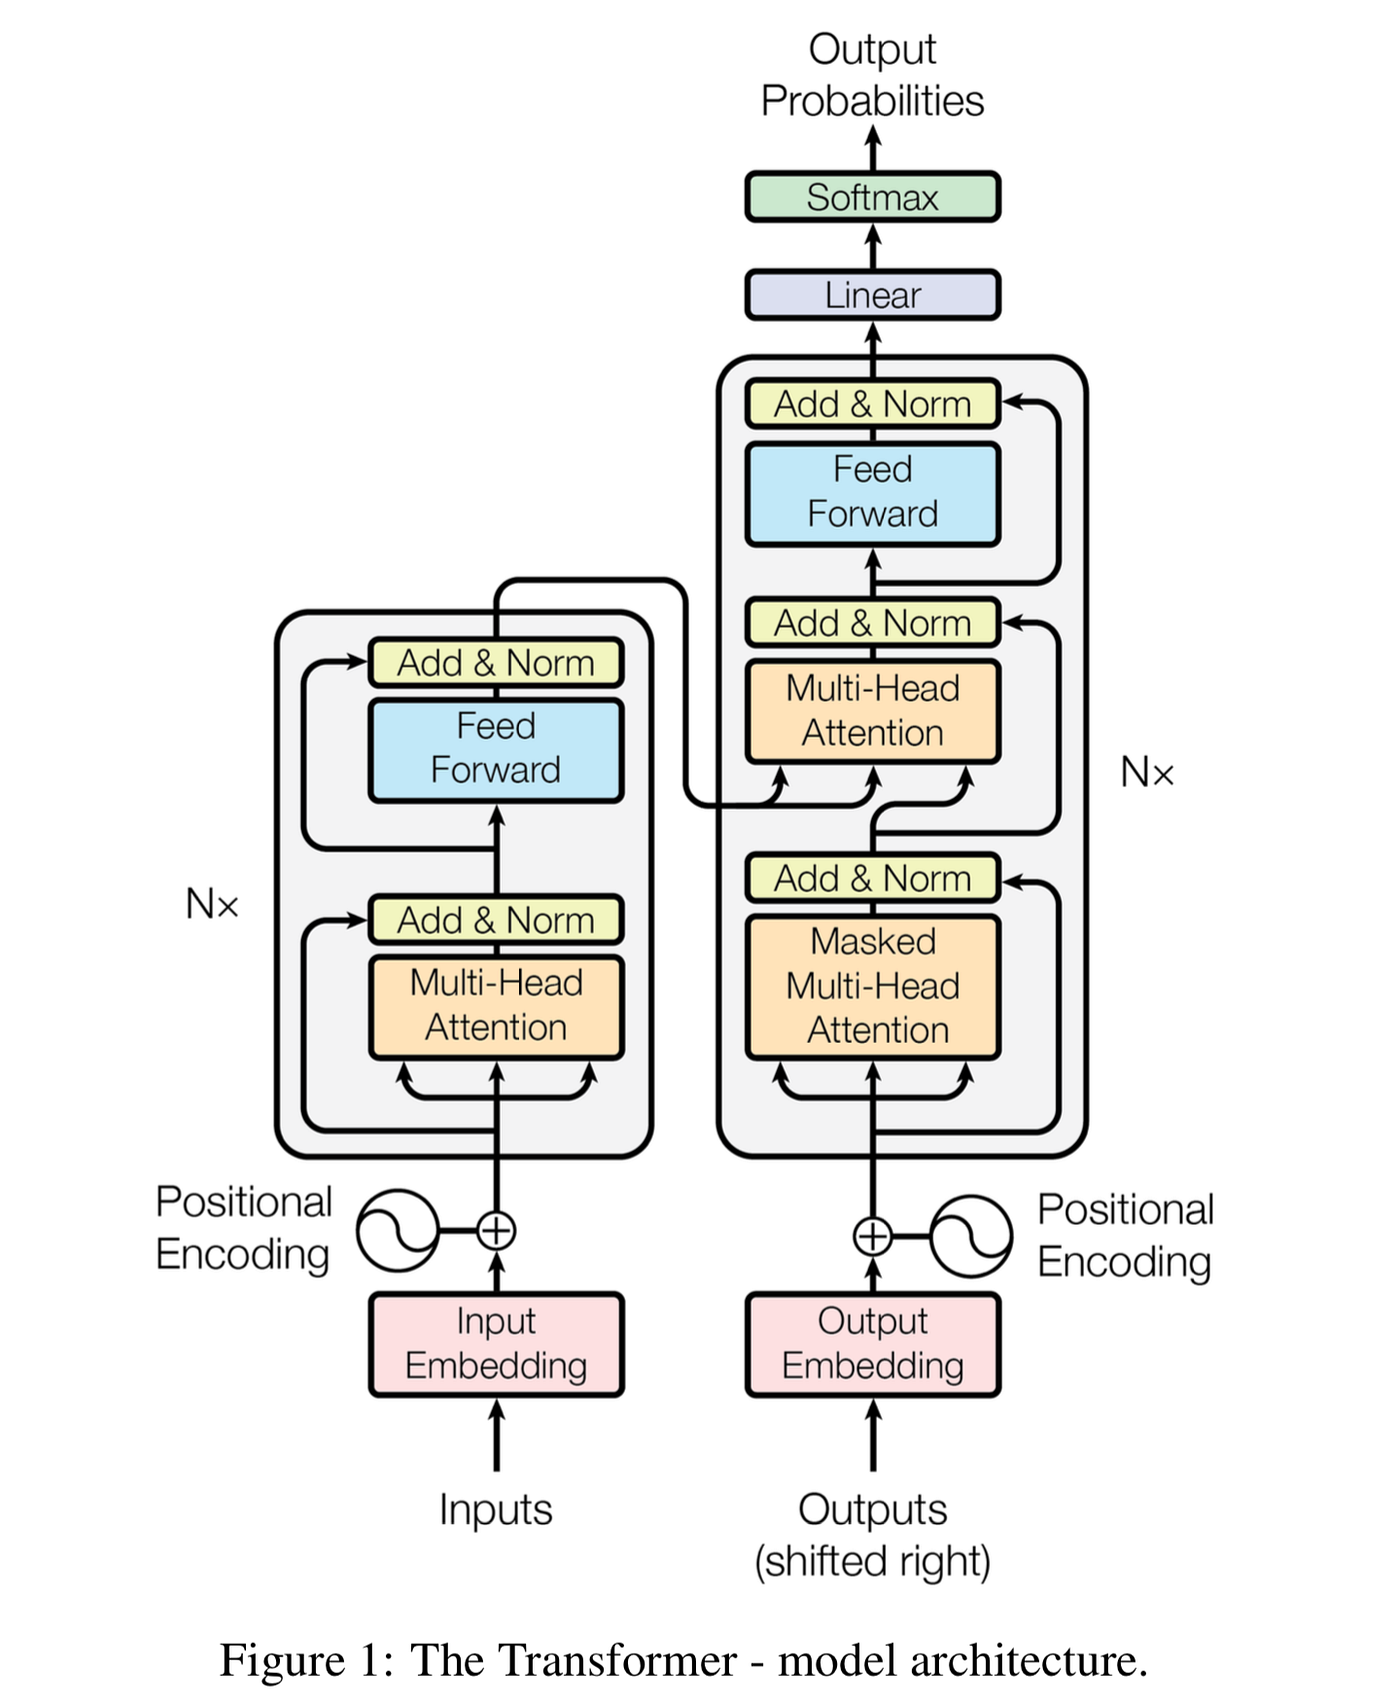

In [1]:
# --- 1. KURULUM ---
# Gerekli kütüphanelerin kurulumu
# datasets==2.19.0: Güvenlik kısıtlamaları nedeniyle daily_dialog gibi veri setleri için eski sürümü sabitliyoruz.
!pip install "datasets==2.19.0" tiktoken gradio torchinfo tqdm

import torch
import torch.nn as nn
from torch.nn import functional as F
from datasets import load_dataset
import tiktoken
from torchinfo import summary
import matplotlib.pyplot as plt
import gradio as gr
from tqdm import tqdm

# Cihaz ayarı (GPU varsa kullan, yoksa CPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"🚀 Kullanılan Cihaz: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.3.1 which is incompatible.
🚀 Kullanılan Cihaz: cuda


## 2. Tokenization ve Input Embeddings

İnsanlar dili harf ve kelimelerle temsil ederken, LLM’ler dili **token**’lara ayırır. Her token'ı bir ID numarası ile işleyerek hesaplama maliyetini düşürür.

> **Süreç:**
> 1.  Metin parçalara bölünür (Tokenization).
> 2.  Her token ID'si, bağlamdan bağımsız bir vektöre (**Embedding**) dönüştürülür.

Burada `DialogSum` veri setini kullanacağız ve modelin diyalog yapısını anlaması için veriyi `User:` ve `Bot:` formatına dönüştüreceğiz.

In [2]:
# --- 2. VERİ HAZIRLIĞI ---

print("📚 Veri seti indiriliyor (knkarthick/dialogsum)...")
dataset = load_dataset("knkarthick/dialogsum", split="train")

text_data = ""
print("Veri işleniyor ve 'User/Bot' formatına çevriliyor...")

# Eğitim hızı için ilk 5000 diyaloğu alıyoruz.
for row in tqdm(dataset.select(range(5000)), desc="Formatlanıyor"):
    raw_dialogue = row['dialogue']
    # Etiketleri değiştiriyoruz (#Person1# -> User)
    clean_dialogue = raw_dialogue.replace("#Person1#:", "User:").replace("#Person2#:", "Bot:")
    # Diyaloğu ana metne ekle ve sonuna "Bitti" (<|endoftext|>) işareti koy
    text_data += clean_dialogue + "\n<|endoftext|>\n"

print(f"✅ Toplam karakter sayısı: {len(text_data)}")

# --- Tokenizer (GPT-2) ---
# Tiktoken: OpenAI'ın kullandığı profesyonel BPE tokenizer
enc = tiktoken.get_encoding("gpt2")

# Metni sayılara (ID'lere) çevir
data = torch.tensor(enc.encode(text_data, allowed_special={"<|endoftext|>"}), dtype=torch.long)

# Eğitim (%90) ve Doğrulama (%10) ayırma
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

print(f"Veri seti hazır! Vocab Size (Sözlük Boyutu): {enc.n_vocab}")

📚 Veri seti indiriliyor (knkarthick/dialogsum)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/12460 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Veri işleniyor ve 'User/Bot' formatına çevriliyor...


Formatlanıyor: 100%|██████████| 5000/5000 [00:01<00:00, 3151.95it/s]


✅ Toplam karakter sayısı: 3498651
Veri seti hazır! Vocab Size (Sözlük Boyutu): 50257


In [11]:
dataset.select(range(5000))[:1]

{'id': ['train_0'],
 'dialogue': ["#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. Why are you here today?\n#Person2#: I found it would be a good idea to get a check-up.\n#Person1#: Yes, well, you haven't had one for 5 years. You should have one every year.\n#Person2#: I know. I figure as long as there is nothing wrong, why go see the doctor?\n#Person1#: Well, the best way to avoid serious illnesses is to find out about them early. So try to come at least once a year for your own good.\n#Person2#: Ok.\n#Person1#: Let me see here. Your eyes and ears look fine. Take a deep breath, please. Do you smoke, Mr. Smith?\n#Person2#: Yes.\n#Person1#: Smoking is the leading cause of lung cancer and heart disease, you know. You really should quit.\n#Person2#: I've tried hundreds of times, but I just can't seem to kick the habit.\n#Person1#: Well, we have classes and some medications that might help. I'll give you more information before you leave.\n#Person2#: Ok, thanks doctor."],
 'summary': ["Mr. S

## 3. Self-Attention: Modelin Kalbi

Dikkat mekanizmaları, özünde, bir yapay zeka modelinin belirli bir anda veri dizisinin hangi kısımlarına "dikkat etmesi" gerektiğini belirlemek için tasarlanmış algoritmalardır.

### Query, Key ve Value (Q, K, V)
Transformer’da her token için bu üç vektör üretilir. Bu yapı, ilişkisel veritabanındaki anahtar–değer mantığını taklit eder. Bir örnek üzerinden gidelim:

**Cümle:** *"Kedi mama yer"*

1.  **Query (Sorgu - Q):** Token ne arıyor?
    * *"Kedi"* token'ı, cümlede bir eylem veya nesne arar ("Ne yapıyor?").
2.  **Key (Anahtar - K):** Diğer tokenlar ne sunuyor?
    * *"Mama"* ve *"Yer"* token'ları kendilerini tanımlayan anahtarları sunar.
3.  **Value (Değer - V):** İçerik nedir?
    * Eğer Query ve Key uyuşursa (Dot Product yüksek çıkarsa), bu Value vektörü kullanılır.

Model bu kelimeler arasındaki ilişkiyi hesapladığında, *"Kedi"* ile *"Yer"* arasındaki etkileşim (Attention Score) yüksek çıkar ve model kedinin beslendiğini anlar.

### Positional Encoding
Transformer'lar veriyi paralel işlediği için sırayı bilmezler. *"Ali köpeği sevdi"* ile *"Köpek Ali'yi sevdi"* arasındaki farkı anlatmak için, her token'a matematiksel bir konum vektörü eklenir.

In [3]:
# --- 3. MODEL AYARLARI (Hiperparametreler) ---
# T4 GPU belleğine sığacak (Safe Pro Config) optimize edilmiş ayarlar.
# Bu ayarları değiştirerek modelin kapasitesiyle oynayabilirsiniz.

batch_size = 16      # Aynı anda işlenen sekans sayısı (Bellek tasarrufu için düşürüldü)
block_size = 192     # Context Window: Model geriye dönük ne kadar metin hatırlayacak?
max_iters = 5000     # Eğitim adım sayısı
learning_rate = 3e-4 # Öğrenme hızı (AdamW için standart)
eval_iters = 200     # Loss hesaplama sıklığı

n_embd = 384         # Embedding boyutu (Modelin "Genişliği" / Nöron sayısı)
n_head = 6           # Attention kafa sayısı (384/6 = 64 boyutlu kafalar)
n_layer = 6          # Transformer katman sayısı (Modelin "Derinliği")
dropout = 0.2        # Overfitting (Ezberlemeyi) önlemek için nöron kapatma oranı

## 4. Model Mimarisi (Kod)

Burada Transformer mimarisini parça parça inşa ediyoruz:

1.  **Head:** Tek bir dikkat mekanizması. Q, K, V hesaplar ve maskeleme yapar.
2.  **MultiHeadAttention:** Birden fazla Head'in paralel çalışması. Biri gramere bakarken diğeri anlama bakabilir.
3.  **FeedForward:** Modelin "düşündüğü" ve öğrendiği nöron katmanı.
4.  **Block:** İletişim (Attention) ve Hesaplama (FeedForward) işlemlerinin birleşimi.
5.  **GPT:** Tüm parçaları birleştiren ana sınıf.

In [4]:
# --- 4. MODEL KODLARI ---

class Head(nn.Module):
    """ Tek bir Self-Attention Kafası """
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        # Maskeleme: Modelin geleceği görmesini engellemek için (Decoder yapısı)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        # 1. Q, K, V Üretimi
        k = self.key(x)   # (B,T,H)
        q = self.query(x) # (B,T,H)

        # 2. Attention Skorları (Dot Product + Scaling)
        # Matris çarpımı ile kelimeler arası ilişkiyi bulur
        wei = q @ k.transpose(-2, -1) * (C**-0.5)

        # 3. Maskeleme (Geleceği görme engeli)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        # 4. Value Aggregation (Bilgiyi topla)
        v = self.value(x)
        out = wei @ v
        return out

class MultiHeadAttention(nn.Module):
    """ Paralel çalışan çoklu dikkat mekanizması """
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(num_heads * head_size, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1) # Çıktıları birleştir
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ Düşünme Katmanı (MLP) """
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd), # Genişlet
            nn.ReLU(),                     # Non-linearity
            nn.Linear(4 * n_embd, n_embd), # Geri daralt
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Tek bir Transformer Bloğu """
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size) # İletişim (Communication)
        self.ffwd = FeedFoward(n_embd)                  # Hesaplama (Computation)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        # Residual Connections (x + ...): Bilginin kaybolmasını önler
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPT(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(enc.n_vocab, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, enc.n_vocab)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        loss = None
        if targets is not None:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens, temperature=0.7):
        # idx: (B, T) boyutunda mevcut bağlam
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]

            # Temperature Scaling: Olasılıkları sivriltir
            logits = logits / temperature

            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

In [5]:
# --- 5. MODEL ÖZETİ ---

model = GPT().to(device)
print("📊 Model Yapısı ve Parametre Detayları:")
# torchinfo ile modelin katmanlarını görselleştiriyoruz
summary(model, input_size=(1, block_size), dtypes=[torch.long], depth=4)

📊 Model Yapısı ve Parametre Detayları:


Layer (type:depth-idx)                        Output Shape              Param #
GPT                                           [1, 192, 50257]           --
├─Embedding: 1-1                              [1, 192, 384]             19,298,688
├─Embedding: 1-2                              [192, 384]                73,728
├─Sequential: 1-3                             [1, 192, 384]             --
│    └─Block: 2-1                             [1, 192, 384]             --
│    │    └─LayerNorm: 3-1                    [1, 192, 384]             768
│    │    └─MultiHeadAttention: 3-2           [1, 192, 384]             --
│    │    │    └─ModuleList: 4-1              --                        442,368
│    │    │    └─Linear: 4-2                  [1, 192, 384]             147,840
│    │    │    └─Dropout: 4-3                 [1, 192, 384]             --
│    │    └─LayerNorm: 3-3                    [1, 192, 384]             768
│    │    └─FeedFoward: 3-4                   [1, 192, 384]            

## 5. Eğitim (Training)

Modeli eğitiyoruz. Burada **Learning Rate Scheduler** kullanarak eğitimin başında hızlı, sonunda hassas öğrenme sağlıyoruz.

* **Loss Function:** CrossEntropy (Tahmin hatası)
* **Optimizer:** AdamW
* **Scheduler:** CosineAnnealing (Hızı yavaş yavaş düşürür)

🚀 GELİŞMİŞ EĞİTİM BAŞLIYOR... (5000 adım)


Eğitim İlerlemesi:   0%|          | 0/5000 [00:26<?, ?it/s, Trn=10.886, Val=10.886]

Adım 0: Train Loss 10.8861, Val Loss 10.8862 | LR: 0.000300


Eğitim İlerlemesi:  10%|█         | 500/5000 [02:37<15:26,  4.86it/s, Trn=3.892, Val=4.008]  

Adım 500: Train Loss 3.8917, Val Loss 4.0083 | LR: 0.000293


Eğitim İlerlemesi:  20%|██        | 1001/5000 [04:47<9:03:16,  8.15s/it, Trn=3.504, Val=3.765]

Adım 1000: Train Loss 3.5039, Val Loss 3.7650 | LR: 0.000272


Eğitim İlerlemesi:  30%|███       | 1501/5000 [06:57<7:55:26,  8.15s/it, Trn=3.188, Val=3.609]

Adım 1500: Train Loss 3.1879, Val Loss 3.6086 | LR: 0.000240


Eğitim İlerlemesi:  40%|████      | 2001/5000 [09:07<6:46:55,  8.14s/it, Trn=2.965, Val=3.501]

Adım 2000: Train Loss 2.9654, Val Loss 3.5007 | LR: 0.000200


Eğitim İlerlemesi:  50%|█████     | 2501/5000 [11:17<5:39:30,  8.15s/it, Trn=2.758, Val=3.461]

Adım 2500: Train Loss 2.7578, Val Loss 3.4614 | LR: 0.000155


Eğitim İlerlemesi:  60%|██████    | 3001/5000 [13:27<4:31:59,  8.16s/it, Trn=2.595, Val=3.446]

Adım 3000: Train Loss 2.5945, Val Loss 3.4456 | LR: 0.000110


Eğitim İlerlemesi:  70%|███████   | 3501/5000 [15:37<3:23:37,  8.15s/it, Trn=2.455, Val=3.447]

Adım 3500: Train Loss 2.4551, Val Loss 3.4467 | LR: 0.000070


Eğitim İlerlemesi:  80%|████████  | 4001/5000 [17:47<2:20:23,  8.43s/it, Trn=2.354, Val=3.434]

Adım 4000: Train Loss 2.3543, Val Loss 3.4343 | LR: 0.000038


Eğitim İlerlemesi:  90%|█████████ | 4501/5000 [19:58<1:07:51,  8.16s/it, Trn=2.299, Val=3.440]

Adım 4500: Train Loss 2.2987, Val Loss 3.4397 | LR: 0.000017


Eğitim İlerlemesi: 100%|██████████| 5000/5000 [22:08<00:00,  3.76it/s, Trn=2.292, Val=3.432]


Adım 4999: Train Loss 2.2917, Val Loss 3.4320 | LR: 0.000010


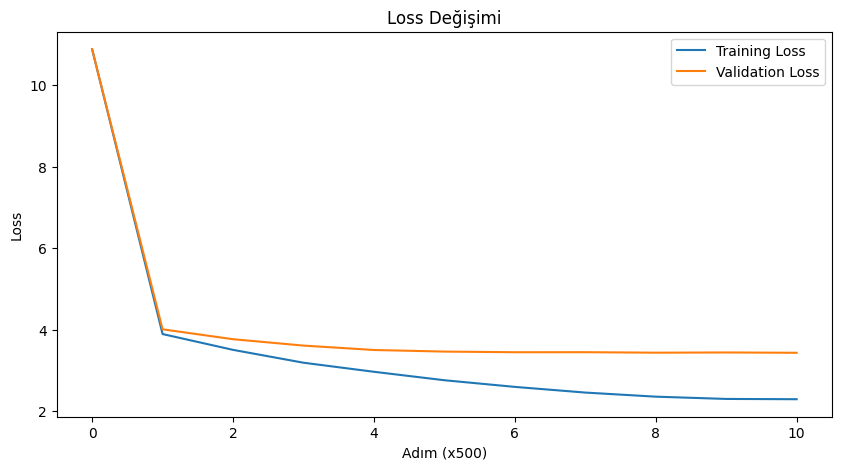

In [6]:
# --- 6. EĞİTİM DÖNGÜSÜ ---

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Scheduler: Öğrenme hızını zamanla düşürür
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_iters, eta_min=1e-5)

def get_batch(split):
    data_src = train_data if split == 'train' else val_data
    ix = torch.randint(len(data_src) - block_size, (batch_size,))
    x = torch.stack([data_src[i:i+block_size] for i in ix])
    y = torch.stack([data_src[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

train_losses = []
val_losses = []

print(f"🚀 GELİŞMİŞ EĞİTİM BAŞLIYOR... ({max_iters} adım)")

# TQDM ile ilerleme çubuğu
pbar = tqdm(range(max_iters), desc="Eğitim İlerlemesi", dynamic_ncols=True)

for iter in pbar:
    # Raporlama
    if iter % 500 == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        current_lr = optimizer.param_groups[0]['lr']

        # Konsol çıktısı ve Bar güncelleme
        tqdm.write(f"Adım {iter}: Train Loss {losses['train']:.4f}, Val Loss {losses['val']:.4f} | LR: {current_lr:.6f}")
        pbar.set_postfix({'Trn': f"{losses['train']:.3f}", 'Val': f"{losses['val']:.3f}"})

        train_losses.append(losses['train'])
        val_losses.append(losses['val'])

    # Batch işlemleri
    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    scheduler.step()

# Loss Grafiği
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Değişimi')
plt.xlabel('Adım (x500)')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
# --- 7. CHAT ARAYÜZÜ ---

def generate_response(user_input, history):
    prompt = f"User: {user_input}\nBot:"
    context = torch.tensor(enc.encode(prompt, allowed_special={"<|endoftext|>"}), dtype=torch.long, device=device).unsqueeze(0)

    model.eval()
    # Temperature 0.6: Daha dengeli cevaplar için
    generated_ids = model.generate(context, max_new_tokens=50, temperature=0.6)

    output_text = enc.decode(generated_ids[0].tolist())
    response = output_text.split("Bot:")[-1].split("User:")[0].strip()
    return response if response else "..."

demo = gr.ChatInterface(
    fn=generate_response,
    title="Baby GPT - Custom Transformer",
    description="Sıfırdan eğitilmiş, DialogSum veri seti kullanan Transformer modeli.",
    examples=["Hi, how are you?", "What is your name?", "Can you help me find my keys?"],
)

# Modeli Kaydet
torch.save(model.state_dict(), "baby_gpt_model.pth")
print("✅ Model kaydedildi: baby_gpt_model.pth")

demo.launch(debug=True)

/usr/local/lib/python3.12/dist-packages/gradio/chat_interface.py:347: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  self.chatbot = Chatbot(


✅ Model kaydedildi: baby_gpt_model.pth
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://b6eefd8e215eb71809.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://b6eefd8e215eb71809.gradio.live
